,Load (%),Start Time,End Time,Duration (s),Mean Power (W)
0,0,2025-09-16 12:46:04.254,2025-09-16 12:55:04.153,539.899,1.078859
1,25,2025-09-16 12:47:34.254,2025-09-16 12:49:04.153,89.899,0.946377
2,50,2025-09-16 12:49:04.254,2025-09-16 12:50:34.153,89.899,1.338197
3,75,2025-09-16 12:50:34.253,2025-09-16 12:52:04.154,89.901,1.662634
4,100,2025-09-16 12:52:04.253,2025-09-16 12:53:34.153,89.900,1.993179


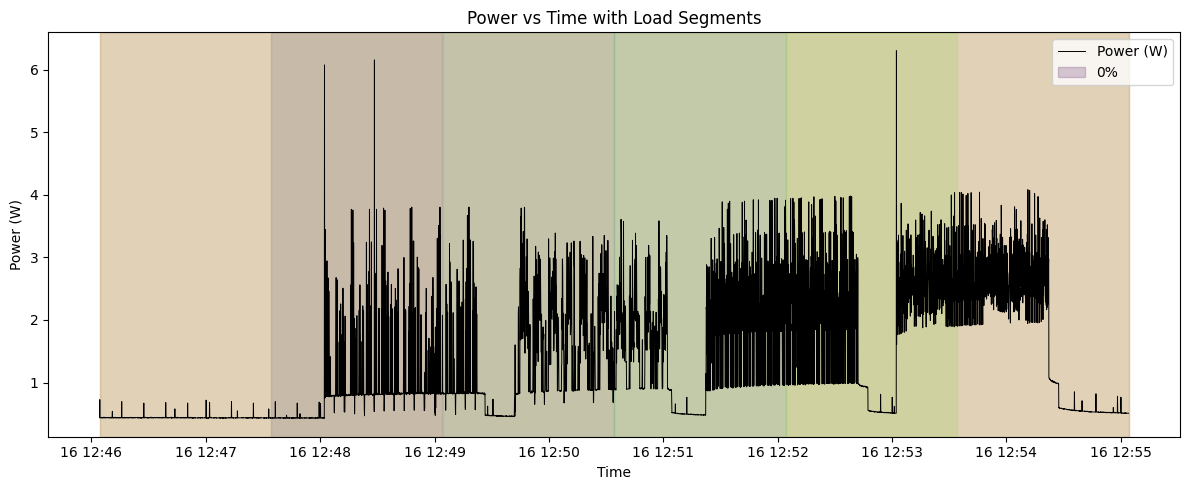

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 1. Load your CSV ===
#file_path = "energy_log_cpu1-00-10-20-30--100.csv"# <-- change to your CSV file
#file_path = "energy_log_cpu1-00-25-50-75-100-00.csv"# <-- change to your CSV file
#file_path = "energy_log_cpu2-00-10-20-30--100.csv"# <-- change to your CSV file
file_path = "energy_log_cpu2-00-25-50-75-100.csv"# <-- change to your CSV file
df = pd.read_csv(file_path)
df['ts'] = pd.to_datetime(df['Timestamp (ISO ms)'], errors='coerce')

# === 2. Define load labels ===
# Choose depending on your experiment:
#load_labels = [0,10,20,30,40,50,60,70,80,90,100,0]   # for 00-10-20-…-100-00
load_labels = [0,25,50,75,100,0]                   # for 00-25-50-…-100-00

# === 3. Assign labels evenly ===
def assign_labels_even(df, load_labels):
    step = len(df)//len(load_labels)
    labels = []
    for i in range(len(load_labels)):
        labels.extend([load_labels[i]]*step)
    while len(labels) < len(df):
        labels.append(load_labels[-1])
    df = df.copy()
    df["LoadLabel"] = labels[:len(df)]
    return df

df = assign_labels_even(df, load_labels)

# === 4. Summarize segments ===
def segment_summary(df):
    summary = []
    for load, seg in df.groupby("LoadLabel"):
        seg = seg.sort_values("ts")
        start_ts = seg["ts"].iloc[0]
        end_ts = seg["ts"].iloc[-1]
        duration = (end_ts - start_ts).total_seconds()
        summary.append({
            "Load (%)": load,
            "Start Time": start_ts,
            "End Time": end_ts,
            "Duration (s)": duration,
            "Mean Power (W)": seg["Power (W)"].mean()
        })
    return pd.DataFrame(summary)

summary_df = segment_summary(df)
display(summary_df)

# === 5. Plot Power vs Time with shaded load regions ===
colors = plt.cm.viridis(np.linspace(0,1,len(load_labels)))

plt.figure(figsize=(12,5))
plt.plot(df['ts'], df['Power (W)'], linewidth=0.7, color="black", label="Power (W)")

for i, load in enumerate(load_labels):
    seg = df[df["LoadLabel"] == load]
    if not seg.empty:
        plt.axvspan(seg['ts'].iloc[0], seg['ts'].iloc[-1],
                    color=colors[i], alpha=0.2, label=f"{load}%" if i==0 else None)

plt.title("Power vs Time with Load Segments")
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.legend()
plt.tight_layout()
plt.show()
